# Paper figures

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import collections, patches
import scipy
from scipy.stats import ttest_ind
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import scanpy as sc
from adjustText import adjust_text
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
sns.set_style("whitegrid")
hex_colors = [mcolors.rgb2hex(color) for color in sns.color_palette('Blues', 5)]


# Figure 1

## C

In [3]:
# Number of receptors

In [6]:
name_map_en = {'cp':'Drug\ntreatment', 
               'lig':'Ligand\nstimulation', 
               'oe':'Overexpression', 
               'sh':'shRNA', 
               'xpr':'CRISPR', 
               'total':'Total'}

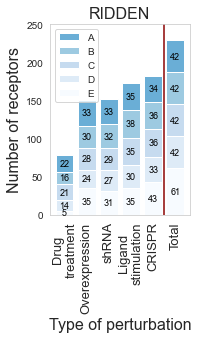

In [11]:
rec_counts = pd.read_csv(f'results/qc/pert_type_receptor_count_hq_with_confidence_barplot.csv', index_col = 0)
rec_counts = rec_counts.sort_index(axis = 1, ascending = False)
def gen_colors(df):
    cmap = sns.color_palette("Blues", as_cmap=True)
    custom_palette = [cmap(x) for x in np.linspace(0, 0.5, df.shape[1])]
    return custom_palette


fig, ax = plt.subplots()
rec_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(2.5, 3.5),
    color=gen_colors(rec_counts),
    width=0.8,  # Adjust bar width (smaller values make thinner bars)
    ax=ax
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=10)

ax.set_xticklabels(rec_counts.index.map(name_map_en))

sns.set_style("white") 
ax.grid(False)  
fig.patch.set_facecolor('white')  
ax.set_facecolor('white') 
for p in ax.patches:
    height = p.get_height()  
    x_position = p.get_x() + p.get_width() / 2
    y_position = p.get_y() + height / 2 
    
    ax.annotate(f'{int(height)}', (x_position, y_position), ha='center', va='center', fontsize=9, color='black')



plt.title('RIDDEN', fontsize=16)
plt.axvline(4.5, color='darkred')
plt.xlabel('Type of perturbation', fontsize=16)
plt.ylabel('Number of receptors', fontsize=16)
plt.ylim(0, 250)
plt.xticks(fontsize=13)

# plt.savefig(f'figures/paper_figures/Fig1B_v2.pdf', transparent=True, bbox_inches='tight')
# plt.savefig(f'figures/paper_figures/Fig1B_v2.jpg', transparent=True, bbox_inches='tight', dpi=350)
# plt.savefig(f'figures/paper_figures/Fig1B_v2.png', transparent=True, bbox_inches='tight', dpi=350)
plt.show()


## D

In [25]:
def add_median_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y+0.03, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='black')

In [15]:
# Confidence
confidence_scores = pd.read_csv(f'results/confidence/receptor_rocauc_mean_confidence_scores_229_mwup_withna.csv', index_col = 0)
confidence_scores_rocauc = pd.read_csv(f'results/confidence/receptor_rocauc_mean_confidence_scores_s0_229.csv', index_col = 0)

In [21]:
conf_merged = confidence_scores_rocauc.merge(confidence_scores, left_on = 'Receptor', right_on = 'Receptor', suffixes = ('_roc', '_mwu'))
# conf_merged = conf_merged[['Receptor', 'ROCAUC', 'mwu_pvalue', 'mwu_stat', 'Confidence_mwu']]

In [23]:

conf_merged[conf_merged['Receptor'] == 'PDCD1']

,Receptor,ROCAUC,Confidence_roc,mwu_pvalue,mwu_stat,Confidence_mwu
129,PDCD1,0.719287,C,0.400749,27282.4,C


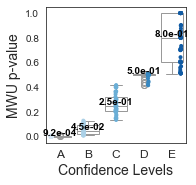

In [44]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

sns.boxplot(data = confidence_scores, y = 'mwu_pvalue', x = 'Confidence', color = 'white', ax = ax)
sns.stripplot(data = confidence_scores, y = 'mwu_pvalue', x = 'Confidence', palette = 'Blues', ax = ax, dodge = True, size = 4)
add_median_labels(ax, fmt = '.1e')

receptor_counts = confidence_scores.groupby('Confidence').agg({'Receptor':'count'})['Receptor']
# for i, cnt in enumerate(ax.get_xticklabels()):
#     count = receptor_counts[cnt.get_text()]
#     ax.text(i, confidence_scores['mwu_pvalue'].max() + 0.085, f'{count}', ha='center', va='bottom', fontsize=14, color='black')
# ax.text(-0.5, confidence_scores['mwu_pvalue'].max() + 0.065, f'Number of\nreceptors', ha='right', va='bottom', fontsize=11, color='black')
ax.set_ylabel('MWU p-value', fontsize =14)
ax.set_xlabel('Confidence Levels', fontsize =14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=10)

# plt.savefig(f'figures/paper_figures/Fig1C.pdf', transparent = True, bbox_inches = 'tight')
# plt.savefig(f'figures/paper_figures/Fig1C.jpg', transparent = True, bbox_inches = 'tight', dpi = 350)
# plt.savefig(f'figures/paper_figures/Fig1C.png', transparent = True, bbox_inches = 'tight', dpi = 350)
plt.show()

# Figures 2

## B

In [34]:
colors = [hex_colors[3], hex_colors[1] , hex_colors[1], hex_colors[1], hex_colors[1], hex_colors[1],'#808080']
custom_palette = sns.color_palette(colors)

In [35]:
# CytoSig

In [38]:
def benchmark_result_boxplot(results:pd.DataFrame, save = False, filepath = '', filename = '', order = [ 'RIDDEN ALL', 'RIDDEN A', 'RIDDEN B', 'RIDDEN C', 'RIDDEN D','RIDDEN E', 'CytoSig'], figsize_x = 4, palette = custom_palette):
    fig, ax = plt.subplots(figsize = (figsize_x,3.5), facecolor='white')
    boxp = sns.boxplot(x='ConfidenceLevel', y='ROC AUC', data=results, color = 'white', linewidth=2, order = order)
    scp = sns.stripplot(x='ConfidenceLevel', y='ROC AUC', data=results, palette = palette, size = 5, order= order)
    add_median_labels(boxp)
    plt.xlabel('Model', fontsize = 14)
    plt.ylabel('ROC AUC', fontsize = 14)
    plt.axhline(0.5, color = 'grey', linestyle = '--', alpha = 0.8)
    plt.xticks(fontsize =12, rotation = 90)
    plt.yticks(fontsize =12)
    plt.ylim(0,1)

    if save:
        if filename=='': raise "No filename was given."
        plt.savefig(f'{filepath}/{filename}.png', dpi = 350, bbox_inches = 'tight', transparent = False)
        plt.savefig(f'{filepath}/{filename}.jpg', dpi = 350, bbox_inches = 'tight', transparent = False)
        plt.savefig(f'{filepath}/{filename}.pdf', bbox_inches = 'tight', transparent = True)

In [39]:
rocauc_results_all = pd.read_csv('results/benchmark/cytosig_lincs_rocauc_confidence_max.csv', index_col = 0)

In [40]:
rocauc_results_all.groupby('ConfidenceLevel').median().sort_values(by = 'ROC AUC', ascending = False)

,ROC AUC
ConfidenceLevel,
RIDDEN A,0.679990
RIDDEN B,0.637037
RIDDEN ALL,0.614671
CytoSig,0.585143
RIDDEN C,0.562783
RIDDEN E,0.524016
RIDDEN D,0.507875


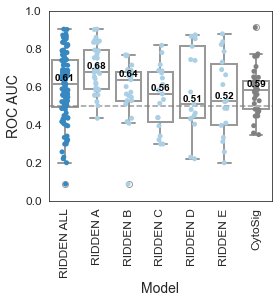

In [45]:
benchmark_result_boxplot(rocauc_results_all, save = False, filepath = f'figures/paper_figures', filename = f'Fig2B')

## C

In [46]:
# ImmuneDict

In [47]:
colors = [hex_colors[3], '#808080', hex_colors[1] , hex_colors[1], hex_colors[1], hex_colors[1], hex_colors[1]]
custom_palette2 = sns.color_palette(colors)

In [48]:
rocaucs_dataframe = pd.read_csv(f'figures/validation/immunedict/immunedict_lincs_rocauc_filtered.csv', index_col = 0)

In [49]:
rocaucs_dataframe.groupby('ConfidenceLevel').median().sort_values(by = 'ROC AUC', ascending = False)

,ROC AUC
ConfidenceLevel,
RIDDEN A,0.843662
CytoSig overlap,0.670893
RIDDEN ALL overlap,0.643401
RIDDEN C,0.613539
RIDDEN D,0.560198
RIDDEN B,0.551384
RIDDEN E,0.442512


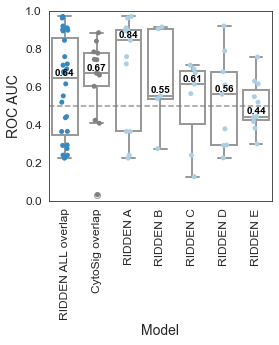

In [50]:
benchmark_result_boxplot(rocaucs_dataframe, save = False, filepath = f'figures/paper_figures', filename = f'Fig2C', 
                         order = [ 'RIDDEN ALL overlap', 'CytoSig overlap', 'RIDDEN A', 'RIDDEN B', 'RIDDEN C', 'RIDDEN D','RIDDEN E'], 
                         palette = custom_palette2)

# Figure3

## A

In [51]:
# Clustering - in receptor_type_clustering.ipynb

## B

In [52]:
# TF activities

In [53]:
tf_receptor_singalling = pd.read_csv(f'results/biological_relevance/kegg_receptor_tf.csv', index_col = 0)


In [54]:
confidence_scores = pd.read_csv(f'results/confidence/receptor_rocauc_mean_confidence_scores_229_mwup_withna.csv', index_col = 0)

In [56]:
tf_receptor_singalling = tf_receptor_singalling.merge(confidence_scores[['Receptor', 'Confidence']], right_on = 'Receptor', left_on = 'receptors')

In [61]:
from scipy.stats import ttest_ind

def tf_receptor_signalling_plot(data: pd.DataFrame, save=False, filepath='', filename=''):
    # Define the color palette for negative (outside pathway) and positive (inside pathway)
    custom_palette = sns.color_palette(['#ECECEC', '#3498db'])  # Neutral gray and blue

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(5.5, 4))  # Adjusted figure size to fit 10 boxes
    # Create the box plot for each confidence level and isinpw category
    sns.boxplot(data=data, x='Confidence', y='activity', hue='isinpw', 
                palette=custom_palette, showfliers=False, ax=ax, order = ['A', 'B', 'C', 'D', 'E'])

    # Customize labels and appearance
    plt.xlabel('Receptor confidence level', fontsize=14)
    plt.ylabel('TF activity', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="TF in pathway", loc='upper center', fontsize=9, ncol=2, title_fontsize=9)
    plt.ylim(-0.5, 3)
    # Show sample sizes and perform t-tests for each confidence level
    confidence_levels = ['A', 'B', 'C', 'D', 'E']
    for i, level in enumerate(confidence_levels):
        # Get data for this confidence level
        outpw = data[(data['isinpw'] == 'No') & (data['Confidence'] == level)]['activity']
        inpw = data[(data['isinpw'] == 'Yes') & (data['Confidence'] == level)]['activity']
        
        # Plot the sample size on the boxes
        ax.text(i - 0.2, np.median(outpw) + 0.25, f'n =\n{len(outpw)}', ha='center', va='center', color='k', fontsize=10)
        ax.text(i + 0.2, np.median(inpw) + 0.25, f'n =\n{len(inpw)}', ha='center', va='center', color='k', fontsize=10)

        # Perform t-test and display results
        ttestres = ttest_ind(outpw, inpw, equal_var=False)
        # print(level, ttestres)
        ax.text(i, -0.4, f"t = {ttestres[0]:.2f}\np = {ttestres[1]:.1e}", ha='center', fontsize=9)

    # Save the figure if needed
    if save:
        plt.savefig(f'{filepath}/{filename}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'{filepath}/{filename}.jpg', dpi=300, bbox_inches='tight')
        plt.savefig(f'{filepath}/{filename}.pdf', transparent = True, bbox_inches='tight')

    plt.show()


In [62]:
df = tf_receptor_singalling.copy()
df['isinpw'] = df.isinpw.map({0:'No', 1:'Yes'})


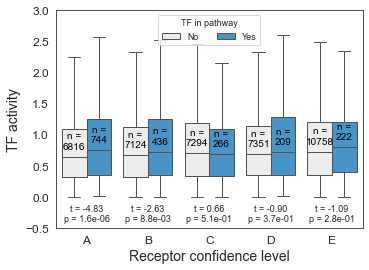

In [63]:
tf_receptor_signalling_plot(df, save = False, filepath = f'figures/paper_figures', filename = 'Fig3B')

## C

In [4]:
# TCGA

In [5]:
tcga_lxr_path = f'results/validation/biological_relevance/receptor_violin_lxr_tcga_log.csv'
tcga_lxr_rand_path = f'results/validation/biological_relevance/correlation_perm_df_lxr_tcga_log.csv'
tcga_rec_path = f'results/validation/biological_relevance/receptor_violin_rec_tcga.csv'
tcga_rec_rand_path = f'results/validation/biological_relevance/correlation_perm_df_rec_tcga.csv'
tcga_lig_path = f'results/validation/biological_relevance/receptor_violin_lig_tcga_log.csv'
tcga_lig_rand_path = f'results/validation/biological_relevance/correlation_perm_df_lig_tcga_log.csv'

In [6]:
# Ligand x Receptor TPM correlations with Receptor activity
tcga_lxr = pd.read_csv(tcga_lxr_path, index_col = 0)
tcga_lxr_rand = pd.read_csv(tcga_lxr_rand_path, index_col = 0)
# # Receptor TPM correlations with Receptor activity
tcga_rec = pd.read_csv(tcga_rec_path, index_col = 0)
tcga_rec_rand = pd.read_csv(tcga_rec_rand_path, index_col = 0)
# Ligand TPM correlations with Receptor activity
tcga_lig = pd.read_csv(tcga_lig_path, index_col = 0)
tcga_lig_rand = pd.read_csv(tcga_lig_rand_path, index_col = 0)

In [7]:
# CCLE

In [8]:
ccle_lxr_path = f'results/validation/biological_relevance/receptor_violin_lxr_ccle.csv'
ccle_lxr_rand_path = f'results/validation/biological_relevance/correlation_perm_df_lxr_ccle.csv'
ccle_rec_path = f'results/validation/biological_relevance/receptor_violin_rec_ccle.csv'
ccle_rec_rand_path = f'results/validation/biological_relevance/correlation_perm_df_rec_ccle.csv'
ccle_lig_path = f'results/validation/biological_relevance/receptor_violin_lig_ccle.csv'
ccle_lig_rand_path = f'results/validation/biological_relevance/correlation_perm_df_lig_ccle.csv'

In [9]:
# Ligand x Receptor TPM correlations with Receptor activity
ccle_lxr = pd.read_csv(ccle_lxr_path, index_col = 0)
ccle_lxr_rand = pd.read_csv(ccle_lxr_rand_path, index_col = 0)
# Receptor TPM correlations with Receptor activity
ccle_rec = pd.read_csv(ccle_rec_path, index_col = 0)
ccle_rec_rand = pd.read_csv(ccle_rec_rand_path, index_col = 0)
# Ligand TPM correlations with Receptor activity
ccle_lig = pd.read_csv(ccle_lig_path, index_col = 0)
ccle_lig_rand = pd.read_csv(ccle_lig_rand_path, index_col = 0)

In [10]:
def correlation_violinplot(receptor_violin:pd.DataFrame, background_correlation:pd.DataFrame, title = '', save_plot_pdf = False, filepath = '',  filename = ''):
    """Plot Violin and calculate Wilcoxon
    
    Parameters
    ----------
    receptor_violin : DataFrame
    background_correlation : DataFrame
    title : str
    save_plot_pdf : bool
    filepath : str
    filename : str
    """
    background_correlation_overlap = background_correlation.loc[background_correlation.index.isin(receptor_violin.index)].copy()
    violin = pd.concat([receptor_violin, background_correlation_overlap])
    # plot

    fig, ax = plt.subplots(figsize = (2.5,4))
    sns.violinplot(data = violin, y = 'value', x = 'source', inner = 'quartile', palette= 'Blues')
    # show only outline
    for collection in ax.collections:
        if isinstance(collection, collections.PolyCollection):
                collection.set_edgecolor(collection.get_facecolor())
                collection.set_facecolor('none')
                collection.set_linewidth(2)

    plt.axhline(0, color = 'k')
    # wilcoxon receptor
    wilc = scipy.stats.wilcoxon(receptor_violin.value, background_correlation_overlap.value)
    r = round(wilc[0], 3)
    p = '{:.1e}'.format(wilc[1])
    text1 = 'Wilcoxon\ns='+str(int(r))+'\np='+str(p)
    # plot text
    plt.text(x = 0.5, y = receptor_violin.value.max()* 0.45, s = text1, fontsize = 14)
    plt.xlabel('')
    plt.ylabel('Correlation', fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 12)
    if title != '':
        plt.title(title, fontsize = 14)
    plt.ylim(-1, 1)
    # plt.legend(loc = 'lower right',fontsize = 14 )
    if save_plot_pdf == True:
        if filepath == '' or filename == '':
            raise ValueError('filepath or filename is missing')
        plt.savefig(f'{filepath}/{filename}.pdf', bbox_inches = 'tight', transparent = True)
        plt.savefig(f'{filepath}/{filename}.png', bbox_inches = 'tight', transparent = True, dpi = 350)
        plt.savefig(f'{filepath}/{filename}.jpg', bbox_inches = 'tight', transparent = True, dpi = 350)
    plt.show()

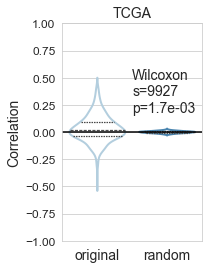

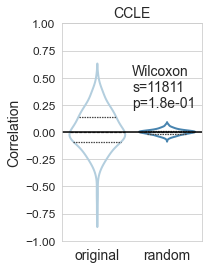

In [11]:
correlation_violinplot(tcga_rec.dropna(), tcga_rec_rand.dropna(), title = 'TCGA', save_plot_pdf = False, filepath = 'figures/paper_figures', filename = 'Fig3C')
correlation_violinplot(ccle_rec.dropna(), ccle_rec_rand.dropna(), title = 'CCLE', save_plot_pdf = False, filepath = 'figures/paper_figures', filename = 'SFig1')


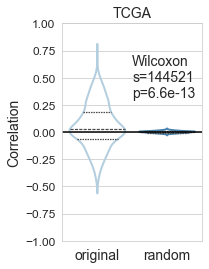

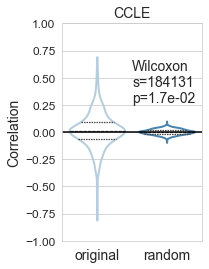

In [13]:
correlation_violinplot(tcga_lxr.dropna(), tcga_lxr_rand.dropna(), title = 'TCGA', save_plot_pdf = False, filepath = 'figures/paper_figures', filename = 'Fig3C')
correlation_violinplot(ccle_lxr.dropna(), ccle_lxr_rand.dropna(), title = 'CCLE', save_plot_pdf = False, filepath = 'figures/paper_figures', filename = 'SFig1')


## Figure 4

## A-C

In [79]:
# KM plots

In [80]:
# Gene expression of patients with renal cell carcinoma
braun_gex = pd.read_csv(f'results/braun_gene_expression.csv', index_col = 0)
braun_gex_1yr = braun_gex[braun_gex['Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy'] <= 365]
# Receptor activity of patients with renal cell carcinoma
braun_rec = pd.read_csv(f'results/braun_receptor_activity.csv', index_col = 0)
braun_rec_1yr = braun_rec[braun_rec['Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy'] <= 365]
braun_rec_moreyrs = braun_rec[braun_rec['Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy'] > 365]

In [81]:
import matplotlib.cm as cm
cmap = cm.get_cmap('RdBu_r')
pal_blue = cmap(0.1)
pal_red = cmap(0.9) 

In [82]:
def km_plot(gene:str, data:pd.DataFrame ,title:str, duration = 'OS', event = 'OS_CNSR', save = False, filepath = '', filename = '', gene_plot = ''):
    kmf = KaplanMeierFitter()
    kmdata = data.copy()
    palette = 'Blues'
    threshold = kmdata[gene].mean()
    
    # log-rank
    low_exp = kmdata[kmdata[gene] <= threshold]
    high_exp = kmdata[kmdata[gene] > threshold]
    results = logrank_test(low_exp[duration], high_exp[duration], event_observed_A=low_exp[event], event_observed_B=high_exp[event])

    cutoffs = [-np.inf, threshold, np.inf]
    labels = ['Low','High']
    kmdata['Activity Levels'] = pd.cut(kmdata[gene], bins=cutoffs, labels=labels)
    fig, ax = plt.subplots(figsize = (2.5,3))
    for category in labels:
        subset = kmdata[kmdata['Activity Levels'] == category]
        kmf.fit(subset[duration], subset[event], label=category)
        if category == 'High': 
            color = pal_blue
            label = f'> mean {gene_plot} (high)'
        else: 
            color = pal_red
            label = f'< mean {gene_plot} (low)'
        kmf.plot(ci_show = False,color = color, label = label, linewidth=2)

    # Add plot labels and legend
    plt.xlabel('Time (months)', fontsize = 14)
    plt.ylabel('Survival Probability', fontsize = 14)
    plt.title(f'{title}', fontsize = 14)
    plt.legend(fontsize = 10)
    plt.ylim(-0.05, 1.05)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12) 

    plt.text(35, 0.45, s = f'log-rank:\nstat = {results.test_statistic:.2f}\np = {results.p_value:.4f}', fontsize = 14)

    if save:
        plt.savefig(f'{filepath}/{filename}.pdf', bbox_inches = 'tight', transparent = True)
        plt.savefig(f'{filepath}/{filename}.png', bbox_inches = 'tight', transparent = True, dpi = 350)
        plt.savefig(f'{filepath}/{filename}.jpg', bbox_inches = 'tight', transparent = True, dpi = 350)

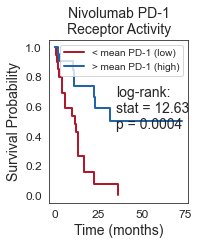

In [83]:
km_plot('PDCD1', braun_rec_1yr[braun_gex_1yr['Arm'] == 'NIVOLUMAB'], title = 'Nivolumab PD-1\nReceptor Activity', 
        save = False, filepath = 'figures/paper_figures', filename = 'Fig4A1', gene_plot='PD-1')


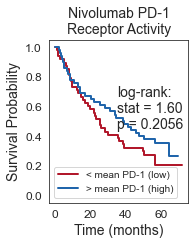

In [84]:
km_plot('PDCD1', braun_rec_moreyrs[braun_rec_moreyrs['Arm'] == 'NIVOLUMAB'], title = 'Nivolumab PD-1\nReceptor Activity', 
        save = False, filepath = 'figures/paper_figures', filename = 'Fig4C', gene_plot='PD-1')


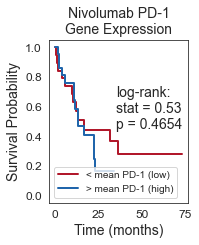

In [85]:
km_plot('PDCD1', braun_gex_1yr[braun_gex_1yr['Arm'] == 'NIVOLUMAB'], title = 'Nivolumab PD-1\nGene Expression', 
        save = False, filepath = 'figures/paper_figures', filename = 'Fig4A2', gene_plot='PD-1')


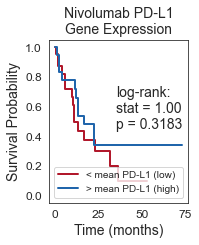

In [86]:
km_plot('CD274', braun_gex_1yr[braun_gex_1yr['Arm'] == 'NIVOLUMAB'], title = 'Nivolumab PD-L1\nGene Expression', 
        save = False, filepath = 'figures/paper_figures', filename = 'Fig4A3', gene_plot='PD-L1')


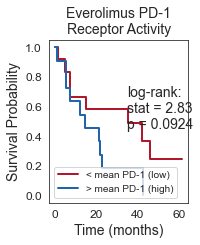

In [87]:
km_plot('PDCD1', braun_rec_1yr[braun_rec_1yr['Arm'] == 'EVEROLIMUS'], title = 'Everolimus PD-1\nReceptor Activity', 
        save = False, filepath = 'figures/paper_figures', filename = 'Fig4B', gene_plot='PD-1')


## D

In [88]:
# Volcano

In [94]:
cox_results_os_nivo = pd.read_csv('results/validation/anti_pd1/bulk/nivo_1yr_cox_receptors.csv', index_col = 0)

In [95]:
confidence_scores = pd.read_csv(f'results/confidence/receptor_rocauc_mean_confidence_scores_229_mwup_withna.csv', index_col = 0)

In [96]:
abreceptors = confidence_scores[confidence_scores['Confidence'].isin(['A', 'B'])].Receptor.unique()
cox_results_os_nivo = cox_results_os_nivo.loc[abreceptors]

In [117]:
cox_results_os_nivo['rank'] = cox_results_os_nivo['Log_Hazard_Ratio'].rank().astype(int)
sign = cox_results_os_nivo[cox_results_os_nivo['P-value'] < 0.05]
sign.sort_values(by = 'Log_Hazard_Ratio').head(10)


,Log_Hazard_Ratio,Hazard_Ratio,P-value,Adjusted p-value,Confidence,rank,log_p
Receptor,,,,,,,
CXCR1,-0.603749,0.546758,0.010260,0.117156,A,1,1.988848
LIFR,-0.545399,0.579610,0.012857,0.117156,A,2,1.890873
NGFR,-0.513008,0.598692,0.028356,0.135787,B,3,1.547358
HCRTR2,-0.486091,0.615026,0.032192,0.135787,A,5,1.492254
SDC2,-0.448328,0.638695,0.034563,0.135848,B,7,1.461392
HCRTR1,-0.437600,0.645584,0.025595,0.135787,A,8,1.591839
NRP2,-0.429998,0.650510,0.033060,0.135787,B,9,1.480691
CXCR2,-0.412927,0.661711,0.027942,0.135787,A,10,1.553740
SSTR4,-0.405381,0.666723,0.032018,0.135787,B,11,1.494604


In [104]:
cox_results_os_nivo['log_p'] = -np.log10(cox_results_os_nivo['P-value'])

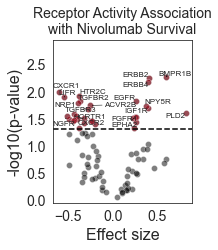

In [107]:
significance_threshold = -np.log10(0.05) 

plt.figure(figsize=(2.5, 3))
sns.scatterplot(data=cox_results_os_nivo, x='Log_Hazard_Ratio', y='log_p', color='k', alpha=0.5)

significant_indices = np.where(cox_results_os_nivo['log_p'] > significance_threshold)[0]
sns.scatterplot(data=cox_results_os_nivo.iloc[significant_indices], x='Log_Hazard_Ratio', y='log_p', color=pal_red, alpha=0.5)
plt.axhline(y=significance_threshold, color='black', linestyle='--')

texts = []
for x, y, name, pval in zip(cox_results_os_nivo['Log_Hazard_Ratio'], cox_results_os_nivo['log_p'], cox_results_os_nivo.index, cox_results_os_nivo['P-value']):
#     if name == 'PDCD1':
#             texts.append(plt.text(x, y, f'{name}', ha='center', fontsize=8, color='red', fontweight='bold'))
    if pval < 0.03:# or (abs(x) > 1.8 and y > significance_threshold): #2 or (abs(x) > 1.5 and y>
        texts.append(plt.text(x, y, f'{name}', ha='center', fontsize=8))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14) 
plt.xlabel('Effect size', fontsize = 16)
plt.ylabel('-log10(p-value)', fontsize = 16)
plt.ylim(-0.05, 2.95)
plt.title('Receptor Activity Association\nwith Nivolumab Survival', fontsize = 14)
# plt.savefig("figures/paper_figures/Fig4D.pdf", bbox_inches="tight", transparent = True)
# plt.savefig("figures/paper_figures/Fig4D.png", bbox_inches="tight", transparent = True, dpi = 350)
# plt.savefig("figures/paper_figures/Fig4D.png", bbox_inches="tight", transparent = True, dpi = 350)

plt.show()

## E

In [108]:
# sc-RNA-Seq

In [109]:
sc_receptor_acts = sc.read("results/validation/anti_pd1/single_cell/receptor_activities_rcc.h5ad")
sc_gene_expression = sc.read("results/validation/anti_pd1/single_cell/gene_expression_rcc.h5ad")


In [404]:
plt.rcParams.update({'axes.titlesize': 16})   
plt.rcParams.update({'axes.labelsize': 14})   

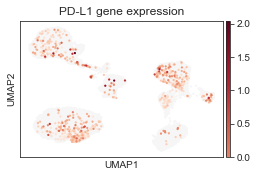

In [111]:
figsize = (4, 2.5)
with plt.rc_context({'figure.figsize': figsize}): 
    sc.pl.umap(sc_gene_expression, color=['CD274'], cmap='RdBu_r', vcenter=0, **{'s': 20, 'alpha':1, 'title' :'PD-L1 gene expression'}, show=False)

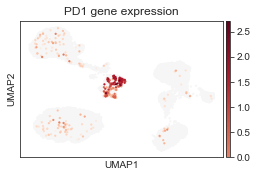

In [112]:
with plt.rc_context({'figure.figsize': figsize}): 
    sc.pl.umap(sc_gene_expression, color=['PDCD1'], cmap='RdBu_r', vcenter=0,**{'s': 20, 'alpha':1, 'title' :'PD1 gene expression'}, show = False)

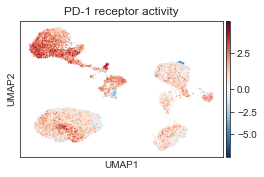

In [124]:
figsize = (4, 2.5)
with plt.rc_context({'figure.figsize': figsize}): 
    sc.pl.umap(sc_receptor_acts, color=['PDCD1'], cmap='RdBu_r', vcenter=0, **{'alpha':1, 'title' :'PD-1 receptor activity'}, show=False)
    # plt.savefig("figures/paper_figures/Fig4E2.pdf", bbox_inches="tight", transparent = True)
    # plt.savefig("figures/paper_figures/Fig4E2.png", bbox_inches="tight", transparent = True, dpi = 300)

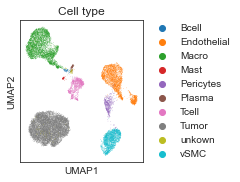

In [118]:
figsize = (2.2, 2.6)

with plt.rc_context({'figure.figsize': figsize}): 
    sc.pl.umap(sc_receptor_acts, color=['cell_type_less'],**{'s': 1, 'alpha':1, 'title' :'Cell type'}, show = False)
    # plt.savefig("figures/paper_figures/Fig4E1.pdf", bbox_inches="tight", transparent = True)
    # plt.savefig("figures/paper_figures/Fig4E1.jpg", bbox_inches="tight", transparent = True, dpi = 350)
    # plt.savefig("figures/paper_figures/Fig4E1.png", bbox_inches="tight", transparent = True, dpi = 350)

## F

In [114]:
data = pd.DataFrame(sc_receptor_acts.X, index = sc_receptor_acts.obs_names, columns = sc_receptor_acts.var_names)
hue = sc_receptor_acts.obs['cell_type_less']
df = pd.merge(data[['PDCD1']], hue, left_index = True, right_index = True)
median_values = df.groupby('cell_type_less')['PDCD1'].median().sort_values()
order = median_values.index

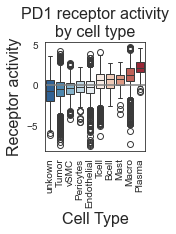

In [115]:
pal_blue = cmap(0.3)

plt.figure(figsize=(1.8, 2))
sns.boxplot(x='cell_type_less', y='PDCD1', data=df, palette= 'RdBu_r', order = list(order))
plt.title('PD1 receptor activity\nby cell type', fontsize = 16)
plt.xticks(rotation = 90, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Cell Type', fontsize = 16)
plt.ylabel('Receptor activity', fontsize = 16)
plt.axhline(0, color = 'gray')
# plt.savefig('figures/paper_figures/Fig4F.pdf' ,bbox_inches = 'tight', transparent = True)
# plt.savefig('figures/paper_figures/Fig4F.png' ,bbox_inches = 'tight', transparent = True, dpi = 350)
# plt.savefig('figures/paper_figures/Fig4F.jpg' ,bbox_inches = 'tight', transparent = True, dpi = 350)


plt.show()